<a href="https://colab.research.google.com/github/amalkoodoruth/deep-learning-for-pkd-patients/blob/main/dicom_dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mounting drive and changing the working directory
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MiCM2021-PKD/dataloader_data_kaggle/Train_Sets/MR

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MiCM2021-PKD/dataloader_data_kaggle/Train_Sets/MR


In [2]:
# installing pydicom
!pip install pydicom

In [3]:
# importing important librarires
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pydicom

In [4]:
my_dir = !pwd
my_dir = str(my_dir)

In [5]:
def load_data(master_path, new_dimensions):
    '''
    This function is used to transform dicom images into numpy arrays with the desired dimensions

      Parameters:
        master_path (str): the path to the directory containing the scans of all patients
        new_dimensions (list): a list containing the dimensions of the new scan [z,x,y]

      Returns:
        patients_resized (numpy.ndarray): a numpy array containing numpy arrays representing MRI scans of individual patients
    '''
    patients_name = os.listdir(master_path)

    patients_dcm = [] # contains the samples in dicom format

    for patient in patients_name:
      path = master_path + '/' + patient + '/T2SPIR/DICOM_anon'
      patients_dcm.append(load_scan(path))

    print("Dicom files loaded")

    scans_not_square = not_square(patients_dcm)
    [min_length, max_length], [min_width, max_width], [min_height, max_height] = get_extreme_dim(patients_dcm)

    patients = []

    for patient in patients_dcm:
      patients.append(get_array(patient))

    print("Dicom files converted to numpy array")

    patients_resized = []
    
    for patient in patients:
      patients_resized.append(resize_data(patient, new_dimensions))
    
    print("Scans have been resized to {size}".format(size= patients_resized[0].shape))

    return patients_resized

def load_scan(path):
    """
    This function is used to load the MRI scans.

      Parameters:
        path (str): The path to the folder containing the MRI scans of THE patient

      Returns:
        slices (list): A list of the slices consisting the MRI scan
    """

    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except Exception as e:
        print("Exception raised: ", e)
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_dimensions(patients_dcm):
    """
    This function is used to get the dimensions of all scans

      Parameters:
        patients_dcm (list): A list containing the MRI scans. Each MRI scan is a list of the slices that make up the scan

      Returns:
        None
    """
    for i in range(len(patients_dcm)):
      print(patients_dcm[i][0].pixel_array.shape, len(patients_dcm[i]))

def not_square(patients_dcm):
    """
    This function tells us if all the slices that make up a scan are squares.

      Parameters:
        patients_dcm (list): A list containing the MRI scans. Each MRI scan is a list of the slices that make up the scan

      Returns:
        scans_not_square (list): A list containing the indices of scans that contain non-square slices
      
    """
    scans_not_square = []
    for i in range(len(patients_dcm)):
      # we compare only the first slice because all of them in one scan have the same dimension
      if patients_dcm[i][0].pixel_array.shape[0] != patients_dcm[i][0].pixel_array.shape[1]: 
        scans_not_square.append(i)
        print("Not all images are squares")

    return scans_not_square

def get_array(scan):
    '''
    This function converts a scan into a numpy array

      Parameters:
        scan (list): A list containing the slices that make up an MRI scan

      Returns: 
        np_image (numpy.ndarray): A numpy array representing the MRI scan
    '''
    image = np.stack([s.pixel_array for s in scan])
    image = image.astype(np.int16)
    np_image = np.array(image, dtype=np.int16)
    return np_image

def resize_data(data, new_dimensions):
    '''
    This function resizes a numpy array.
    TO DO: method used for interpolation?

      Parameters:
        data (numpy.ndarray): a numpy array representing an MRI scan
        new_dimensions (list): a list containing the dimensions of the new scan [z,x,y]

      Returns:
        new_data (numpy.ndarray): a numpy array with the desired dimensions
    '''
    initial_size_x = data.shape[1]
    initial_size_y = data.shape[2]
    initial_size_z = data.shape[0]

    new_size_z = new_dimensions[0]
    new_size_x = new_dimensions[1]
    new_size_y = new_dimensions[2]
      
    delta_x = initial_size_x / new_size_x
    delta_y = initial_size_y / new_size_y
    delta_z = initial_size_z / new_size_z

    new_data = np.zeros((new_size_z, new_size_x, new_size_y))

    for x, y, z in itertools.product(range(new_size_x),
                                      range(new_size_y),
                                      range(new_size_z)):
      new_data[z][x][y] = data[int(z * delta_z)][int(x * delta_x)][int(y * delta_y)]

    return new_data

def get_extreme_dim(patients_dcm):
    """
    This function gets the minimum and maximum dimensions of all scans

      Paramters:
        patients_dcm (list): A list containing the MRI scans. Each MRI scan is a list of the slices that make up the scan

      Returns:
        [min_length, max_length], [min_width, max_width], [min_height, max_height] (list): These lists contain the
        minimum and maximum dimensions of all scans.

    """
    lengths = []
    widths = []
    heights = []
    square = True

    scans_not_square = not_square(patients_dcm)

    if len(scans_not_square) != 0:
      square = False

    # for i in range(len(patients_dcm)):
    #   if patients_dcm[i][0].pixel_array.shape[0] != patients_dcm[i][0].pixel_array.shape[1]: 
    #     square = False
    #     print("Not all images are squares")

    for i in range(len(patients_dcm)):

      lengths.append(patients_dcm[i][0].pixel_array.shape[0])
      heights.append(len(patients_dcm[i]))
      if square == False:
        widths.append(patients_dcm[i][0].pixel_array.shape[1])
    
    max_length = max(lengths)
    min_length = min(lengths)

    max_height = max(heights)
    min_height = min(heights)

    print("Min length: {min_l} \nMax length: {max_l}\n".format(max_l= max_length, min_l= min_length))
    if square == False:
      max_width = max(widths)
      min_width = min(widths)
      print("Min width: {min_w} \nMax width: {max_w}\n".format(max_w= max_width, min_w= min_width))
    else:
      min_width, max_width = -1,-1
      print("All images are squares\n")
      
    print("Min height: {min_h} \nMax height: {max_h}\n".format(max_h= max_height, min_h= min_height))

    return [min_length, max_length], [min_width, max_width], [min_height, max_height]

In [19]:
pat = load_data(my_dir[2:-2], [20,500,500])

Dicom files loaded
Min length: 256 
Max length: 320

All images are squares

Min height: 26 
Max height: 39

Dicom files converted to numpy array
Scans have been resized to (20, 500, 500)


In [20]:
pat[0].shape

(20, 500, 500)

In [21]:
print(load_data.__doc__)


    This function is used to transform dicom images into numpy arrays with the desired dimensions

      Parameters:
        master_path (str): the path to the directory containing the scans of all patients
        new_dimensions (list): a list containing the dimensions of the new scan [z,x,y]

      Returns:
        patients_resized (numpy.ndarray): a numpy array containing numpy arrays representing MRI scans of individual patients
    


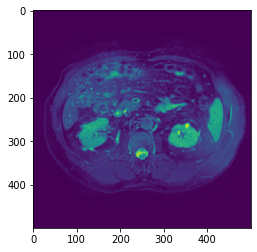

In [22]:
plt.imshow(pat[0][5,:,:])